House Prices: Advanced Regression Techniques

This project is a compeition in Kaggle with initially 79 features for the residential homes in Ames, Iowa. The goal of this challenge is to predict the final price of each home.
As usual, data exploration, feature engineering are applied, then several machine learning models are built to predict the house price in the test set.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.stats import skew
%matplotlib inline

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Functions which are used in this project. They can also be reused in other projects.

In [34]:
# Returns a concatenated dataframe of training and test set on axis 0
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

# Returns divided dfs of training and test set
def divide_df(all_data, sizeof_first):
    return all_data.loc[:sizeof_first-1,:], all_data.loc[sizeof_first:,:]    

# Onehot encoding function
def onehot_features(data, cols):
    multicols = data[cols]
    multicols = multicols.astype(str)
    one_hot = pd.get_dummies(multicols)
    return one_hot

# Feature scaling function
def scaling(data,cols):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), cols)
    return scaled_data

# Map categorical strings in the features to numbers
def map_category(series, mapping):
    digit_data = series.map(mapping)
    return digit_data

#Function to measure accuracy.
def rmlse(val, target):
    return np.sqrt(np.sum(((np.log1p(val) - np.log1p(np.expm1(target)))**2) / len(target)))

Data Exploration

In [35]:
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [37]:
df_train.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [38]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


                   Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id           1.000000    0.011156    -0.010601 -0.033226    -0.028365   
MSSubClass   0.011156    1.000000    -0.386347 -0.139781     0.032628   
LotFrontage -0.010601   -0.386347     1.000000  0.426095     0.251646   
LotArea     -0.033226   -0.139781     0.426095  1.000000     0.105806   
OverallQual -0.028365    0.032628     0.251646  0.105806     1.000000   

             OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id              0.012609  -0.012713     -0.021998   -0.050298   -0.005024   
MSSubClass     -0.059316   0.027850      0.040581    0.022936   -0.069836   
LotFrontage    -0.059213   0.123349      0.088866    0.193458    0.233633   
LotArea        -0.005636   0.014228      0.013788    0.104160    0.214103   
OverallQual    -0.091932   0.572323      0.550684    0.411876    0.239666   

             ...  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
Id           ...   -0.02964

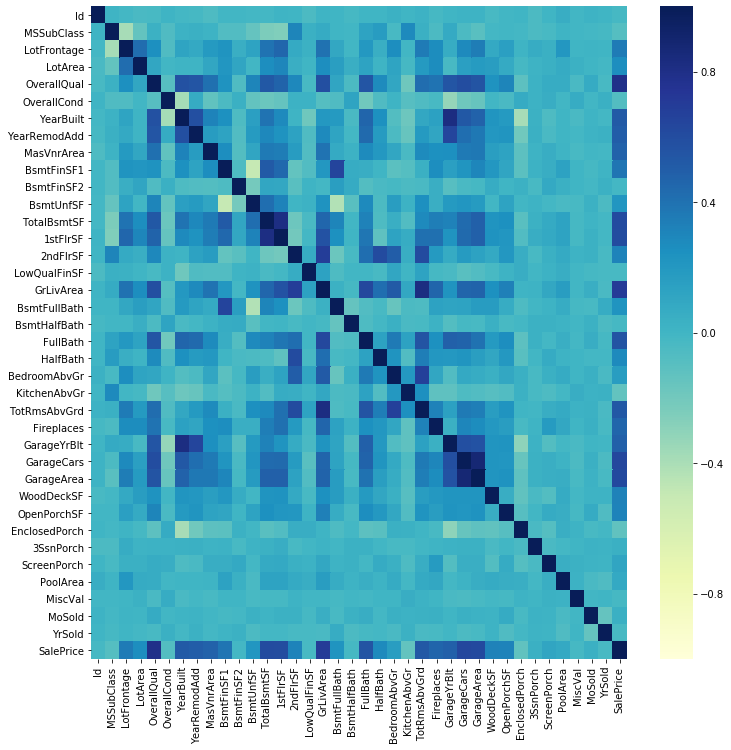

In [39]:
# Heatmap on training set including sales price to observe the Pearson correlations.
corr = df_train.corr(method = 'pearson')
print(corr.head())

plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, vmin=-1, cmap="YlGnBu" )

Note:
1. Large negative correlations are equaly important as large positive values in machine learning.
2. Pearson correlations can only represent numerical values including categorical ordinal feature values.
3. Pearson correlations only measure linear correlations. It does not work well when there is non-linear relation between two features. Therefore, there might be other relations even though the correlation values are low between some features.


The figure below can also show that there is lower correlation between lot area size and sale price.

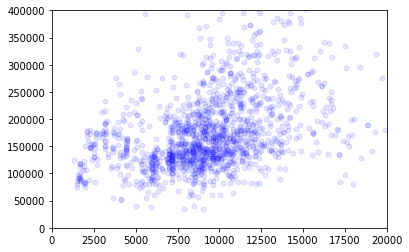

0.2638433538714063


In [40]:
jitter = 150
x = df_train['LotArea']
y = df_train['SalePrice'] + np.random.uniform(-jitter, jitter, len(df_train))
#y = df_train['SalePrice']

plt.plot(x, y, 'o', markersize=5, alpha=0.1, color = 'Blue')
# Limit Sale Price range within 50000 as only limited lot area data greater than 20000 better easier observation.
plt.xlim(0,20000)
# Same reason to limit sale price
plt.ylim(0,400000)
plt.xlabel=('Lot Area')
plt.ylabel=('Sale Price')
plt.show()

print(corr.loc['LotArea', 'SalePrice'])

The figure below can also show that there is higher correlation between built year and sale price.

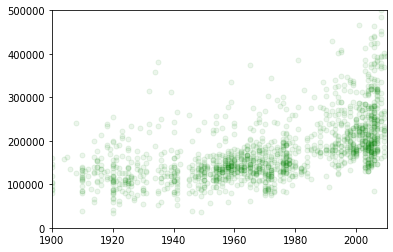

0.5228973328794967


In [41]:
jitter = 150
x = df_train['YearBuilt']
y = df_train['SalePrice'] + np.random.uniform(-jitter, jitter, len(df_train))

plt.plot(x, y, 'o', markersize=5, alpha=0.08, color = 'Green')
plt.xlim(1900,2010)
plt.ylim(0, 500000)

plt.xlabel=('YearBuilt')
plt.ylabel=('Sale Price')
plt.show()

print(corr.loc['YearBuilt', 'SalePrice'])

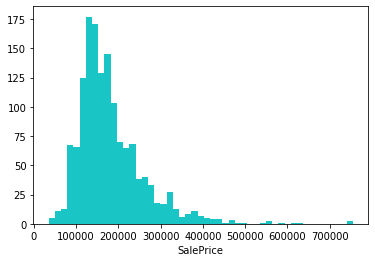

In [42]:
#It seems that SalePrice is skewered, so it needs to be transformed. Will do it later.
sns.distplot(df_train['SalePrice'], kde=False, color='c', hist_kws={'alpha': 0.9})

In [43]:
# Extract the house prices to a new series
y_train = df_train['SalePrice']
df_train.drop('SalePrice', axis=1, inplace=True)

# Remove Id columns from both training and test set
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

# Check the data shape now
print(df_train.shape)
print(df_test.shape)
print(y_train.shape)

(1460, 79)
(1459, 79)
(1460,)


Check the null values in training set

In [44]:
df_nu = df_train.isnull().sum()

# Only list the features with null values for later processing
print(df_nu[df_nu > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Check the null values in test set

In [45]:
df_nu = df_test.isnull().sum()

# Only list the features with null values for later processing
print(df_nu[df_nu > 0])

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


There are 4 features 'Alley','PoolQC','Fence','MiscFeature' with almost all null values. Merge training and test data first then remove the 4 features.

In [46]:
# Merge training and test set to process feature engineering together
df_all = concat_df(df_train, df_test)
print(df_all.shape)

(2919, 79)


In [47]:
df_all.drop(['Alley','PoolQC','Fence','MiscFeature'], axis = 1, inplace= True)

Initially fill in the null values for all features with null values above.

In [48]:
df_all['MSZoning'].fillna('RL', inplace=True) # test set only
df_all['LotFrontage'].fillna(df_all['LotFrontage'].mean(), inplace =True)       
df_all['Utilities'].fillna('AllPub', inplace=True) # test set only
df_all['Exterior1st'].fillna('VinylSd', inplace=True) # test set only
df_all['Exterior2nd'].fillna('VinylSd', inplace=True) # test set only
df_all['MasVnrType'].fillna('None', inplace=True) 
df_all['MasVnrArea'].fillna('0', inplace=True)

df_all['BsmtQual'].fillna('TA', inplace=True)
df_all['BsmtCond'].fillna('TA', inplace=True)
df_all['BsmtExposure'].fillna('No', inplace=True)
df_all['BsmtFinType1'].fillna('GLQ', inplace=True)
df_all['BsmtFinType2'].fillna('Unf', inplace=True)
df_all['BsmtFinSF1'].fillna('0', inplace=True) # test set only
df_all['BsmtFinSF2'].fillna('0', inplace=True) # test set only
df_all['BsmtUnfSF'].fillna(df_all['BsmtUnfSF'].median(), inplace=True) # test set only
df_all['TotalBsmtSF'].fillna(df_all['BsmtUnfSF'].median(), inplace=True) # test set only
df_all['BsmtFullBath'].fillna('0', inplace=True) # test set only
df_all['BsmtHalfBath'].fillna('0', inplace=True) # test set only

df_all['Electrical'].fillna('SBrkr', inplace=True) # training set only
df_all['KitchenQual'].fillna('TA', inplace=True) # test set only
df_all['Functional'].fillna('Typ', inplace=True) # test set only
df_all['FireplaceQu'].fillna('TA', inplace=True)
       
df_all['GarageType'].fillna('Attchd', inplace=True)
df_all['GarageYrBlt'].fillna(df_all['GarageYrBlt'].mean(), inplace=True)
df_all['GarageFinish'].fillna('RFn', inplace=True)
df_all['GarageCars'].fillna('2', inplace=True) #test set only
df_all['GarageArea'].fillna(df_all['GarageArea'].mean(), inplace=True) #test set only
df_all['GarageQual'].fillna('TA', inplace=True)
df_all['GarageCond'].fillna('TA', inplace=True)
 
df_all['SaleType'].fillna('WD', inplace=True) #test set only

# Make sure there is no null items
df_all.isnull().sum()

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
BedroomAbvGr     0
BldgType         0
BsmtCond         0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFinType1     0
BsmtFinType2     0
BsmtFullBath     0
BsmtHalfBath     0
BsmtQual         0
BsmtUnfSF        0
CentralAir       0
Condition1       0
Condition2       0
Electrical       0
EnclosedPorch    0
ExterCond        0
ExterQual        0
Exterior1st      0
Exterior2nd      0
FireplaceQu      0
Fireplaces       0
Foundation       0
FullBath         0
Functional       0
GarageArea       0
                ..
LotArea          0
LotConfig        0
LotFrontage      0
LotShape         0
LowQualFinSF     0
MSSubClass       0
MSZoning         0
MasVnrArea       0
MasVnrType       0
MiscVal          0
MoSold           0
Neighborhood     0
OpenPorchSF      0
OverallCond      0
OverallQual      0
PavedDrive       0
PoolArea         0
RoofMatl         0
RoofStyle        0
SaleCondition    0
SaleType         0
ScreenPorch 

Now, handle several types of features in different ways:
1. Do one-hot encoding for categorical and norminal data
2. For categorical and ordinal data, map all values to numbers
3. Do normalization and scaling finally for all features - including both categorical data and regression data. It's not essential (optioanl) for tree related algorithms.

In [49]:
# Check the data summary so far
print(df_all.columns)
print(df_all.head())
print(df_all.shape)

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BldgType',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu',
       'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea',
       'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope',
       'LotArea', 'LotConfig', 'LotFrontage', 'LotShape', 'LowQualFinSF',
       'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscVal',
       'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       

Use one-hot encoding to handle categorical + norminal features below: 
MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
Foundation
Heating
CentralAir
Electrical
Functional
GarageType
GarageFinish
MoSold
SaleType
SaleCondition


In [50]:
cols = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'MoSold', 'SaleType', 'SaleCondition']
onehot = onehot_features(df_all, cols)

# Drop the original features
df_all.drop(cols, axis = 1, inplace = True)

print(type(onehot))
print(onehot.shape)
print(df_all.shape)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
(2919, 191)
(2919, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 48 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null object
BsmtFinSF2       2919 non-null object
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null object
BsmtHalfBath     2919 non-null object
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
FireplaceQu      2919 non-null object
Fireplaces       2919 non-null int64
FullBath         2919 non-null int64
GarageArea       2919 non-null float64
GarageCars       2919 non-null object
G

Map all the categorical ordianl features which the order of the values make sense and their values are not numerical below:
ExterQual
ExterCond
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
HeatingQC
KitchenQual
FireplaceQu
GarageQual
GarageCond
PavedDrive
PoolQC
Fence

The mappings can be determined by referring the data_description file which describes the meanings of each features.

In [51]:
mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, 'Av':3, 'Mn':2, 'No':1}
df_all['ExterQual'] = df_all['ExterQual'].astype(str)
df_all['ExterQual'] = df_all['ExterQual'].map(mapping)
df_all['ExterCond'] = map_category(df_all['ExterCond'], mapping)
df_all['BsmtQual'] = map_category(df_all['BsmtQual'], mapping)
df_all['BsmtCond'] = map_category(df_all['BsmtCond'], mapping)
df_all['BsmtExposure'] = map_category(df_all['BsmtExposure'], mapping)
df_all['HeatingQC'] = map_category(df_all['HeatingQC'], mapping)
df_all['KitchenQual'] = map_category(df_all['KitchenQual'], mapping)
df_all['FireplaceQu'] = map_category(df_all['FireplaceQu'], mapping)
df_all['GarageQual'] = map_category(df_all['GarageQual'], mapping)
df_all['GarageCond'] = map_category(df_all['GarageCond'], mapping)

mapping = {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'NA':0}
df_all['BsmtFinType1'] = map_category(df_all['BsmtFinType1'], mapping)
df_all['BsmtFinType2'] = map_category(df_all['BsmtFinType2'], mapping)

mapping = {'Y':2, 'P':1, 'N':0}
df_all['PavedDrive'] = map_category(df_all['PavedDrive'], mapping)

# The following features are still type object but they should be numbers. Convert them to int64. 
df_all['BsmtFinSF1'] = df_all['BsmtFinSF1'].astype(int)
df_all['BsmtFinSF2'] = df_all['BsmtFinSF2'].astype(int)
df_all['BsmtFullBath'] = df_all['BsmtFinSF2'].astype(int)
df_all['BsmtHalfBath'] = df_all['BsmtFinSF2'].astype(int)
df_all['GarageCars'] = df_all['BsmtFinSF2'].astype(int)
df_all['MasVnrArea'] = df_all['BsmtFinSF2'].astype(int)

Transform skewed features.

In [52]:
for col in df_all.columns:
    if skew(df_all[col]) > 0.75:
        df_all[col] = np.log1p(df_all[col])

y_train = np.log1p(y_train)

 Merge dummy features and original data set.

In [53]:
df_all = pd.concat([df_all, onehot], axis=1)
print(df_all.shape)

(2919, 239)


In [54]:
df_nu = df_all.isnull().sum()

# Make sure if there is no null value
print(df_nu[df_nu>0])

Series([], dtype: int64)


In [55]:
# Check the data set dimensions so far again.
print(df_train.shape)
print(df_all.shape)
X_train, X_test = divide_df(df_all, df_train.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(1460, 79)
(2919, 239)
(1460, 239)
(1459, 239)
(1460,)


Scaling features

In [56]:
col = X_train.columns
X_train = X_train.astype(float)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = col)

print(X_train.head())

col = X_test.columns
X_test = X_test.astype(float)
scaler = StandardScaler()
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = col)

   1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  \
0 -0.803645  1.180528  -0.128521      0.163779 -0.038577     -0.653819   
1  0.418479 -0.870117  -0.128521      0.163779 -0.038577      2.060930   
2 -0.576677  1.184762  -0.128521      0.163779 -0.038577      0.547477   
3 -0.439421  1.143550  -0.128521      0.163779  3.481550     -0.653819   
4  0.112127  1.244087  -0.128521      1.390023 -0.038577      1.399810   

   BsmtFinSF1  BsmtFinSF2  BsmtFinType1  BsmtFinType2  ...  SaleType_ConLw  \
0    0.779431   -0.355342      1.116589     -0.334107  ...       -0.058621   
1    0.888257   -0.355342      0.631549     -0.334107  ...       -0.058621   
2    0.654803   -0.355342      1.116589     -0.334107  ...       -0.058621   
3    0.384539   -0.355342      0.631549     -0.334107  ...       -0.058621   
4    0.754400   -0.355342      1.116589     -0.334107  ...       -0.058621   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0     -0.301962  

PCA transformation

As the heapmap shows most of the correlations between two features are low, it's possible that PCA transformation/ decomposition
cannot imrove performance, or even loss some information after PCA. Will still try the result to compare anyway.

In [57]:
pca = PCA(200, whiten=True, random_state=42).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train.shape)
print(type(X_train_pca))

(1460, 239)
<class 'numpy.ndarray'>


Discard polynomail features due to lack of data samples comparing number of features

In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

poly = PolynomialFeatures(degree = 2).fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print(X_train_poly.shape)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train_poly, y_train, test_size = 0.3, random_state = 42)

# Apply Ridge (L2) to polynomial features
ridge = Ridge(alpha = 1000).fit(X_train_t, y_train_t)

pred = np.expm1(ridge.predict(X_test_t))
print(rmlse(pred, y_test_t))

(1460, 28920)
0.1949388383401124


In [59]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

# For PCA features
X_train_t_pca, X_test_t_pca, y_train_t_pca, y_test_t_pca = train_test_split(X_train_pca, y_train, test_size = 0.25, random_state = 42)

Linear Regression model with L2 regularization

In [60]:
from sklearn.linear_model import LinearRegression

ridge = Ridge(alpha = 1200).fit(X_train_t, y_train_t)
pred = np.expm1(ridge.predict(X_test_t))
print(rmlse(pred, y_test_t))

0.13661380149924862


Implement Tree algorithms - Random Forest

Without PCA

In [61]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth = 20, random_state = 42, n_estimators = 100)
rf = clf.fit(X_train_t, y_train_t)
pred = np.expm1(rf.predict(X_test_t))
print(rmlse(pred, y_test_t))

0.144377262828692


With PCA

In [62]:
clf = RandomForestRegressor(max_depth = 20, random_state = 42, n_estimators = 100)
rf = clf.fit(X_train_t_pca, y_train_t_pca)
pred = np.expm1(rf.predict(X_test_t_pca))
print(rmlse(pred, y_test_t_pca))

0.1691094468138285


The result for PCA meet the earlier guess - PCA does not help to improve the performance in this project, so will not apply PCA.


XG-Boost algorithm

In [63]:
import xgboost as xgb

clf = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.1)
xgb = clf.fit(X_train_t, y_train_t)
#score=cross_val_score(clf, X_train, y_train, cv=k_fold)

pred = np.expm1(xgb.predict(X_test_t))
rmlse(pred, y_test_t)

[16:14:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.12892279900319936

In [64]:
pred = np.expm1(xgb.predict(X_test))
np.savetxt('D:\ML\Kaggle projects\House Prices Advanced Regression Techniques\predict.csv', pred)

The score (RMSLE) based on XG-Boost in this file is 0.13515 on Kaggle.